In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from kornia import augmentation

from tqdm.auto import tqdm
import base64
import matplotlib
from io import BytesIO
from PIL import Image
from IPython.display import HTML

In [2]:
from nca.utils import conv_same
import torchvision

In [3]:
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches="tight", pad_inches=0.1)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [4]:
def gif_from_pils(pils, fps):
    fp = BytesIO()
    pils[0].save(
        fp,
        format="gif",
        save_all=True,
        append_images=pils[1:],
        duration=1000 / fps,
        loop=0,
    )
    fp.seek(0)
    
    b64 = base64.b64encode(fp.read()).decode("ascii")
    html = f"""<img src="data:image/gif;base64,{b64}" />"""
    return HTML(html)

In [5]:
def make_gif(nca_out, fps=10, size=(500, 500)):
    nca_out = torch.pow(nca_out, 1)
    seq_out = nca_out.detach().cpu().numpy()
    pil_arrs = (plt.cm.viridis(seq_out)[:,:,:,:3] * 255).astype(np.uint8)
    pils = [Image.fromarray(arr).resize(size, Image.NEAREST) for arr in pil_arrs]
    
    fp = BytesIO()
    pils[0].save(
        fp,
        format="gif",
        save_all=True,
        append_images=pils[1:],
        duration=1000 / fps,
        loop=0,
    )
    fp.seek(0)
    
    b64 = base64.b64encode(fp.read()).decode("ascii")
    html = f"""<img src="data:image/gif;base64,{b64}" />"""
    return HTML(html)

In [24]:
class SimpleNCA(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        perc = 30
        hid = 10

        self.seed = nn.Parameter(torch.rand(32, 64) / 10)
        self.kernel = nn.Sequential(
            nn.Dropout2d(0.1),
            conv_same(1, perc, ks=5, padding_mode="zeros", bias=True),
            nn.ReLU(),
            conv_same(perc, perc, ks=3, padding_mode="zeros", bias=True),
            nn.ReLU(),
        )

        self.rule = nn.Sequential(
            conv_same(perc, hid, ks=1, bias=True),
            nn.ReLU(),
            conv_same(hid, 1, ks=1, bias=True),
        )

        for p in self.kernel.parameters():
            nn.init.uniform_(p, -1, 1)
        for p in list(self.rule.parameters()):
            nn.init.uniform_(p, -0.05, 0.05)

    def forward(self, x, steps):
        x += self.seed
        seq = [x]
        dt = 1
        for i in range(steps):
            perc = self.kernel(x)
            y = self.rule(perc)
#             mask = (torch.rand_like(y) > 0.1).to(torch.float32)
            x = torch.clamp(x + dt * y, 0, 1)
            seq.append(x)

        seq = torch.stack(seq, axis=1)
        return seq

In [41]:
nca = SimpleNCA()

inp = torch.zeros(3, 1, 32, 64)
out = nca(inp, steps=50)


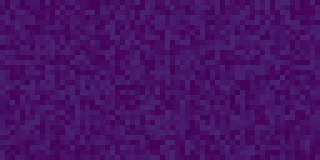

In [42]:
make_gif(out[1,:,0], size=(64 * 5, 32 * 5))

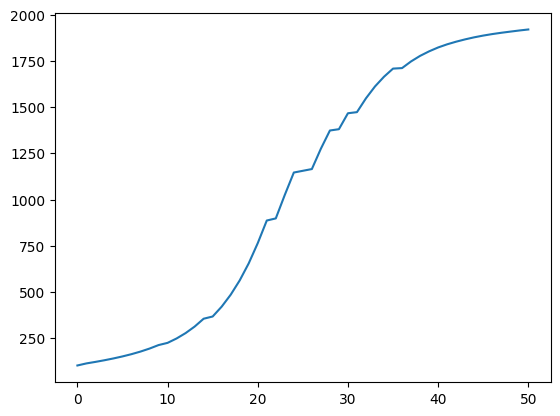

In [43]:
single = out[1,:,0]
vals = single.reshape(single.shape[0], -1).sum(axis=1)
vals = vals.detach().cpu().numpy()
plt.plot(vals)

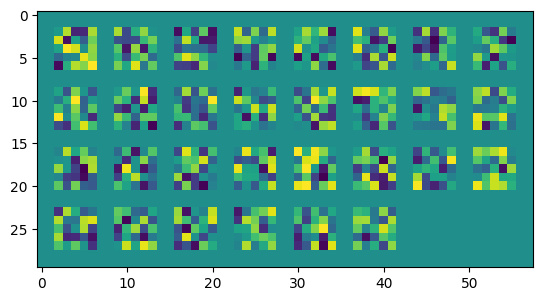

In [44]:
k = nca.kernel[1].weight.data.detach().cpu()
k.shape
plt.imshow(torchvision.utils.make_grid(k)[0])

In [45]:
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchdata.datapipes.iter import IterableWrapper

In [46]:
ds = MNIST(root="./.data", download=True, transform=ToTensor())

In [47]:
bs = 64
num_classes = 10
dl = DataLoader(IterableWrapper(ds).filter(lambda x: x[1] < num_classes), batch_size=bs, shuffle=True)

/home/iz/.cache/pypoetry/virtualenvs/nca-ar8j7Liq-py3.10/lib/python3.10/site-packages/torch/utils/data/datapipes/utils/common.py:145: UserWarning: Lambda function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(
/home/iz/.cache/pypoetry/virtualenvs/nca-ar8j7Liq-py3.10/lib/python3.10/site-packages/torch/utils/data/graph_settings.py:90: UserWarning: `shuffle=True` was set, but the datapipe does not contain a `Shuffler`. Adding one at the end. Be aware that the default buffer size might not be sufficient for your task.
  warnings.warn(


In [48]:
batch = next(iter(dl))

In [49]:
def sample_random_input(dl):
    it = iter(dl)
    while True:
        try:
            x, y = next(it)
        except StopIteration:
            it = iter(dl)
        bs, _, H, W = x.shape
        screen_W, screen_H = 64, 32
        top, left = 2, 2
#         offset = int(20 + np.random.rand() * 10)
        offset = 10
        screen = torch.zeros(bs, 1, screen_H, screen_W)
        screen[:, :, top:top+H, left:left+W] = x

        screen_y = torch.zeros(bs, 1, screen_H, screen_W)
        screen_y[:, :, top:top+H, offset + left: offset + left+W] = x
        
        extractor = lambda screen, i: \
            screen[:, -i:, :, top:top+H, offset + left: offset + left+W]

        yield {"inp": screen, "target": x, "extractor": extractor}

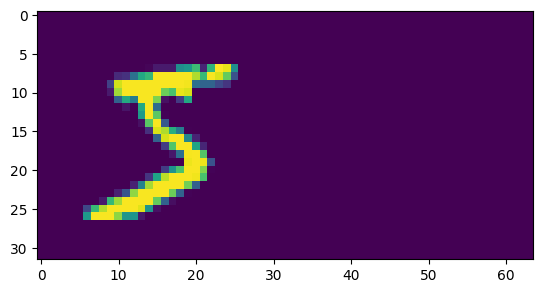

In [50]:
gen = sample_random_input(dl)
batch = next(gen)
im = batch["inp"][0,0]
plt.imshow(im)

In [51]:
np.random.rand()

0.751252250469826


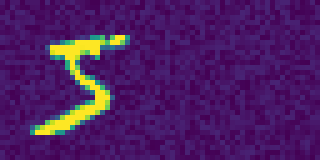

In [52]:
out = nca(batch["inp"], steps=40)
make_gif(out[0,:,0], size=(64 * 5, 32 * 5))

In [53]:
def optim_step(nca, batch, optim, device):
    screen = batch["inp"].to(device)
    y = batch["target"].to(device)
    out = nca(screen, steps=50)
    last = 5
    out = batch["extractor"](out, last).mean(axis=1)
    loss = F.mse_loss(out, y)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    return loss

In [54]:
from copy import deepcopy

In [55]:
lr = 0.0005
target_nca = deepcopy(nca)
optim = torch.optim.Adam(target_nca.parameters(), lr=lr)
history = []

In [56]:
device = "cuda"
target_nca = target_nca.to(device)

In [57]:
from IPython.display import clear_output

Loss: 0.1224919334:   8%|7         | 800/10001 [01:17<14:20, 10.69it/s]

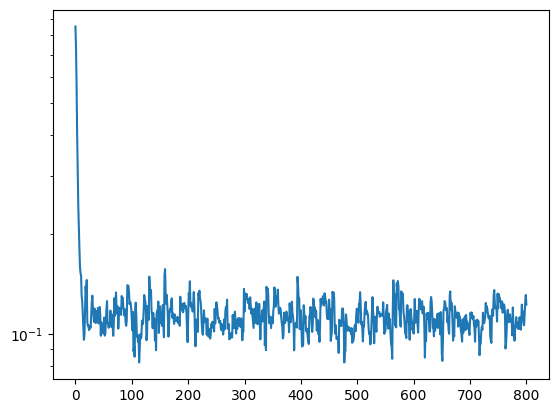


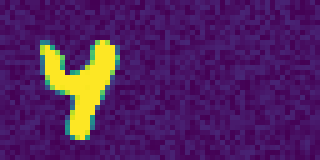


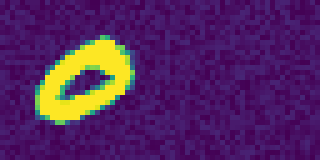


KeyboardInterrupt



In [58]:
pbar = tqdm(range(10001))
for i in pbar:
    batch = next(gen)
    loss = optim_step(target_nca, batch, optim, device)
    pbar.set_description(f"Loss: {loss:.10f}")
    history.append(loss.item())
    
    if i % 200 == 0:
        clear_output(wait=True)
        display(pbar.container)
        plt.plot(history)
        plt.yscale("log")
        plt.show()

        screen = batch["inp"].to(device)
        out = target_nca(screen, steps=80)
        display(make_gif(out[0,:,0], size=(64 * 5, 32 * 5), fps=20))
        display(make_gif(out[1,:,0], size=(64 * 5, 32 * 5), fps=20))

In [ ]:
x, y = batch
x = x.to(device)
y = y.to(device)
out = target_nca(x, steps=40)

In [ ]:
plt.plot(history)
plt.show()

In [ ]:
x, y = batch
x = x.to(device)
y = y.to(device)
out = target_nca(x, steps=100)

In [ ]:
display(make_gif(out[0,:,0], size=(64 * 5, 32 * 5), fps=20))
display(make_gif(out[1,:,0], size=(64 * 5, 32 * 5), fps=20))
display(make_gif(out[2,:,0], size=(64 * 5, 32 * 5), fps=20))
display(make_gif(out[3,:,0], size=(64 * 5, 32 * 5), fps=20))
display(make_gif(out[4,:,0], size=(64 * 5, 32 * 5), fps=20))